In [1]:
#******* Configure Notebook using Magics *******

# load extension to reload modules before executing user code
%load_ext autoreload
# reload all modules (except those excluded by %aimport) every time before executing the code
%autoreload 2
# interactive and 3D plotting
%matplotlib qt5
# enable PyQt5/PySide2 event loop integration
%gui qt5

In [1]:
# custom imports
from utils.helper_functions import Rereference, Data

# standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from scipy import signal
import json
import random
from IPython.display import display
from tabulate import tabulate
from scipy.fft import fft, fftfreq

# third-party libraries
from pymatreader import read_mat
import mne
from nilearn import plotting

# ignore UserWarnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# check matplotlib backend
plt.rcParams._get_backend_or_none()

'module://matplotlib_inline.backend_inline'

# Load Data

Load .mat file and .xlsx file, first holding the raw data and some metadata such as which picture was shown, marks for picture shown and picture placed and the latter holding iEEG channel information.

The resulting loaded data will be a data file holding

class Data():
    def __init__(self, path_to_filepaths_file, experiment_phase_of_interest, fs, verbose=False):
        self.path_to_filepaths_file = path_to_filepaths_file
        self.experiment_phase_of_interest = experiment_phase_of_interest
        self.fs = fs
        self.verbose = verbose
        self.full = self.ieeg = self.df_exp = self.df_chan = None
        
        # initiate variables
        self.dataone_filtered = None
        self.df_exp = None
        self.df_chan = None
        
        if self.verbose: print("initializing Data object...")
        if self.verbose: print(f"path_to_filepaths_file: {repr(self.path_to_filepaths_file)}")
        if self.verbose: print(f"experiment_phase_of_interest: {repr(self.experiment_phase_of_interest)}")
        if self.verbose: print(f"fs: {repr(self.fs)} Hz")
        
        # get filepaths and single subject ID
        if self.verbose: print("getting filepaths...")
        self.filepaths, self.subject_id = self.get_filepaths()
        if self.verbose: 
            for key, value in self.filepaths.items():
                print(f"{key}: {repr(value)}")
        if self.verbose: print(f"subject ID is {repr(self.subject_id)}")
        
        # get single subject data
        if self.verbose: print(f"loading subject {self.subject_id} data...")
        self.full = self.get_ieegdataone()
        if self.verbose: print("use <Class>.full to access full data (including metadata)")
        
        # create own instance of data of interest
        self.ieeg = self.full['data'][f'ieeg_data{self.experiment_phase_of_interest}']
        if self.verbose: print("use <Class>.ieeg to only access iEEG data")
        
        # create dataframe of metadata
        if self.verbose: print("creating dataframe of experiment metadata...")
        self.df_exp = self.get_experiment_meta()
        
        # create dataframe of channel metadata
        if self.verbose: print("creating dataframe of channel metadata...")
        self.df_chan = self.get_channel_meta()
        
        if self.verbose: print("successfully initialized Data object\n")
        
    def get_filepaths(self):
        filepaths = json.loads(open(self.path_to_filepaths_file).read())
        subject_id = filepaths['single_subject'].split('sub')[-1][0:2]
        return filepaths, subject_id
    
    def get_ieegdataone(self):
        return read_mat(self.filepaths['single_subject'])
    
    def get_experiment_meta(self):
        """Parse subject experiment metadata as Pandas dataframe"""
        df = pd.DataFrame(self.full['data'][f'file{self.experiment_phase_of_interest}'], columns=['x_coordinate', 'y_coordinate', 'Picture Number', 'Reaction Time (RT)'])
        df['Picture Number'] = df['Picture Number'].map(int)
        if self.verbose: print("creating new columns 'Mark for Picture Shown' and 'Mark for Picture Placed'...")
        df['Mark for Picture Shown'] = pd.Series(self.full['data'][f'mark{self.experiment_phase_of_interest}'][0::2]).map(int)
        df['Mark for Picture Placed'] = pd.Series(self.full['data'][f'mark{self.experiment_phase_of_interest}'][1::2]).map(int)
        if self.verbose: print("creating new columns 'Timestamp (s) for Picture Shown' and 'Timestamp (s) for Picture Placed'...")
        df['Timestamp (s) for Picture Shown'] = df['Mark for Picture Shown'].apply(lambda x: x/self.fs)
        df['Timestamp (s) for Picture Placed'] = df['Mark for Picture Placed'].apply(lambda x: x/self.fs)
        if self.verbose: print("creating new column 'Reaction Time (computed)'...")
        df['Reaction Time (computed)'] = df['Timestamp (s) for Picture Placed'] - df['Timestamp (s) for Picture Shown']
        return df
    
    def get_channel_meta(self):
        """Get channel metadata as Pandas dataframe"""
        return pd.read_excel(self.filepaths['single_subject_ieeg_chan'], engine='openpyxl')
    
    # def get_unique_electrodes(self, x: np.array = None) -> np.array:
    #     """get_unique Find unique electrodes based on names in a numpy array
        
    #     Args:
    #         x (np.array): Array with electrode names. Default is None.
        
    #     Returns:
    #         unique_arr (np.array): Array with unique electrode names.
    #     """
    #     tmp_list = []
    #     for i in range(len(x)):
    #         tmp_list.append(x[i].split(' ')[0])
    #     unique_arr = np.sort(np.unique(tmp_list))
    #     return unique_arr
    
    # def bipolar(self, direction: str = 'right', inplace: bool = False):
    #     """Bipolar re-referencing of channel data uses a neighbouring contact as reference.
        
    #     Args:
    #         direction (str): The direction of the bipolar referencing. If 'right' the n+1 channel will
    #                          substracted from the n channel. If 'left' the n channel will be 
    #                          substracted from the n+1 channel. Default is 'right'.
    #         inplace (bool): If True, the data will be re-referenced inplace. Default is False.
            
    #     Returns:
    #         new_data (ndarray): Re-referenced data with N-1 channels.
    #     """
    #     if self.verbose: print("re-referencing method: 'bipolar'")
    #     if self.verbose: print(f"{'will perform re-referencing inplace' if inplace else 'will not perform re-referencing inplace'}")
    #     if self.verbose: print(f"direction for substraction operation: {direction}")
        
    #     if inplace==False:
    #         self.ieeg = copy.deepcopy(self.ieeg)
    #     else:
    #         self.ieeg = self.ieeg
            
    #     # get the unique channels names from ch_names
    #     unique_electrodes = self.get_unique_electrodes(self.df_chan['name'].to_numpy())
    #     # tmp list find indices in list matching electrode name
    #     tmp_ch_names = np.array([s.split(' ')[0] for s in self.df_chan['name'].to_numpy()])[0]
    #     print(tmp_ch_names)
        
    #     remove_indices = []
    #     # iterate over unique electrodes
    #     for electrode in unique_electrodes:
    #         indices = np.where(tmp_ch_names == electrode)[0]
    #         # iterate over N-1 contacts for each electrode
    #         # iterate over all channels - 1
    #         for i in range(len(indices) - 1):
    #             if direction == 'right':
    #                 # subtract the next channel from the current channel
    #                 self.ieeg[indices[i], :] = self.ieeg[indices[i], :] - self.ieeg[indices[i + 1], :]
    #             elif direction == 'left':
    #                 # subtract the previous channel from the current channel
    #                 self.ieeg[indices[i + 1], :] = self.ieeg[indices[i + 1], :] - self.ieeg[indices[i], :]
    #         # remove the last channel depending on the direction
    #         if direction == 'right':
    #             remove_indices.append(indices[-1])
    #         elif direction == 'left':
    #             remove_indices.append(indices[0])
    #         if self.verbose: print(f"removing channels {self.df_chan['name'].to_numpy()[remove_indices]} (indices: {remove_indices})")
    #         self.ieeg = np.delete(self.ieeg, remove_indices, axis=0)
    #         self.df_chan['removed'] = [True if i in remove_indices else False for i in range(len(self.df_chan))]
    #         if self.verbose: print(f"see df_chan['removed'] for removed channels")
    #     # remove the first or last contact (channel) in each electrode depending on the direction of the subtraction
    #     np.delete(self.data, remove_indices, axis=0)
    #     if self.verbose: print("successfully re-referenced data.")
    #     return self.data
    
    # def laplacian(self, inplace: bool = False):
    #     """Laplacian re-referencing of channel data uses the average of neighbouring contacts as reference.
        
    #     Args:
    #         inplace (bool): If True, the data will be re-referenced inplace. Default is False.
            
    #     Returns:
    #         new_data (ndarray): Re-referenced data with N-2 channels.
    #     """
    #     if self.verbose: print("re-referencing method: 'laplacian'")
    #     if self.verbose: print(f"{'will perform re-referencing inplace' if inplace else 'will not perform re-referencing inplace'}")
        
    #     if inplace==False:
    #         self.ieeg = copy.deepcopy(self.ieeg)
    #     else:
    #         self.ieeg = self.ieeg
        
    #     # get the unique channels names
    #     unique_electrodes = self.get_unique_electrodes(self.df_chan['name'].to_numpy())
    #     # tmp list find indices in list matching electrode name
    #     tmp_ch_names = np.array([s.split(' ')[0] for s in self.df_chan['name'].to_numpy()])[0]
    #     print(tmp_ch_names)
        
    #     remove_indices = []
    #     # iterate over unique electrodes
    #     for electrode in unique_electrodes:
    #         indices = np.where(tmp_ch_names == electrode)[0]
    #         # iterate over N-1 contacts for each electrode
    #         # iterate over all channels - 1
    #         for i in range(len(indices) - 1):
    #             if direction == 'right':
    #                 # subtract the next channel from the current channel
    #                 self.ieeg[indices[i], :] = self.ieeg[indices[i], :] - self.ieeg[indices[i + 1], :]
    #             elif direction == 'left':
    #                 # subtract the previous channel from the current channel
    #                 self.ieeg[indices[i + 1], :] = self.ieeg[indices[i + 1], :] - self.ieeg[indices[i], :]
    #         # remove the last channel depending on the direction
    #         if direction == 'right':
    #             remove_indices.append(indices[-1])
    #         elif direction == 'left':
    #             remove_indices.append(indices[0])
    #         if self.verbose: print(f"removing channels {self.df_chan['name'].to_numpy()[remove_indices]} (indices: {remove_indices})")
    #         self.ieeg = np.delete(self.ieeg, remove_indices, axis=0)
    #         self.df_chan['removed'] = [True if i in remove_indices else False for i in range(len(self.df_chan))]
    #         if self.verbose: print(f"see df_chan['removed'] for removed channels")
    #     # remove the first or last contact (channel) in each electrode depending on the direction of the subtraction
    #     np.delete(self.data, remove_indices, axis=0)
    #     if self.verbose: print("successfully re-referenced data.")
    #     return self.data

In [4]:
#******** Variable definitions ********
path_to_filepaths_file = './data/filepaths.json'
experiment_phase_of_interest = '2'                  # '1' is preview, '2' is learning, '3' is pre-sleep, and '4' is post-sleep


#******** Static definitions ********
fs = 512


#******** Initiate data object ********
data = Data(path_to_filepaths_file, experiment_phase_of_interest, fs, verbose=False)
print("experiment metadata dataframe:")
display(data.df_exp.head())
print("channel metadata dataframe:")
display(data.df_chan.head())

experiment metadata dataframe:


,x_coordinate,y_coordinate,Picture Number,Reaction Time (RT),Mark for Picture Shown,Mark for Picture Placed,Timestamp (s) for Picture Shown,Timestamp (s) for Picture Placed,Reaction Time (computed)
0,-59.0,-225.0,43,680.0,5119,6226,9.998047,12.160156,2.162109
1,302.0,203.0,20,780.0,7826,9002,15.285156,17.582031,2.296875
2,-125.0,211.0,4,820.0,10605,11824,20.712891,23.093750,2.380859
3,255.0,189.0,36,1380.0,13430,15125,26.230469,29.541016,3.310547
4,366.0,170.0,35,620.0,16724,17768,32.664062,34.703125,2.039062


channel metadata dataframe:


,elec_index,elec_label,DK_ROI,Prob,Lobe,x17Networks,Prob_1,x7Networks,Prob_2,BN_atlas,...,brodmann,Prob_4,perc_VTPM,Prob_5,Var16,data_chan,loc_1,loc_2,loc_3,name
0,1,101,ctx_lh_insula,0.41,Ins,Networks_8,0.60,Networks_7,0.63,INS_L_6_2,...,48,0.47,left_FEF,0.11,NaN,1,-33.712607,50.475984,16.131243,H 01
1,2,102,ctx_lh_insula,0.55,Ins,Networks_8,0.68,Networks_6,0.59,OrG_L_6_6,...,47,0.85,left_FEF,0.26,NaN,2,-36.396940,51.926302,17.808901,H 02
2,3,103,ctx_lh_insula,0.47,Ins,Networks_8,0.68,Networks_6,0.58,OrG_L_6_6,...,47,0.98,left_FEF,0.23,NaN,3,-39.019792,53.300565,19.452807,H 03
3,4,104,ctx_lh_lateralorbitofrontal,0.43,F,Networks_17,0.61,Networks_7,0.64,OrG_L_6_6,...,47,0.99,left_FEF,0.17,NaN,4,-41.813438,54.743383,21.239072,H 04
4,5,105,ctx_lh_parstriangularis,0.31,F,Networks_17,1.00,Networks_7,1.00,IFG_L_6_5,...,47,1.00,left_FEF,0.09,NaN,5,-44.582630,56.166276,23.033039,H 05


# Explore Data

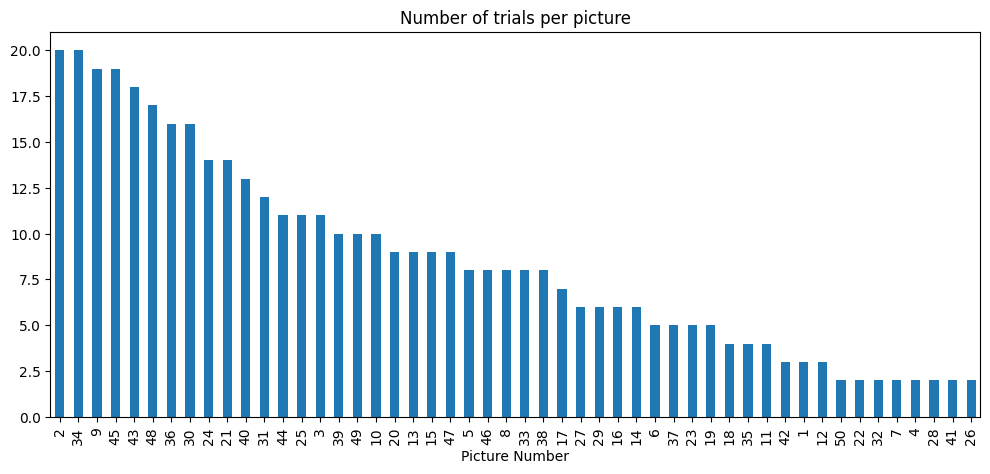

In [4]:
%matplotlib inline

# Number of trials per picture
plt.figure(figsize=(12,5))
data.df_exp['Picture Number'].value_counts().plot(kind='bar', title='Number of trials per picture')
plt.show()

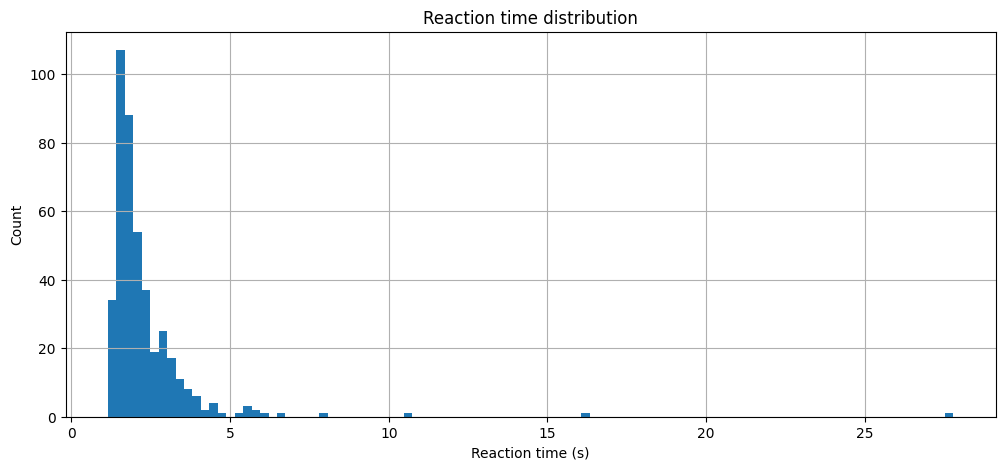

In [5]:
# Reaction time distribution
plt.figure(figsize=(12,5))
data.df_exp['Reaction Time (computed)'].hist(bins=100)
plt.title('Reaction time distribution')
plt.xlabel('Reaction time (s)')
plt.ylabel('Count')
plt.show()

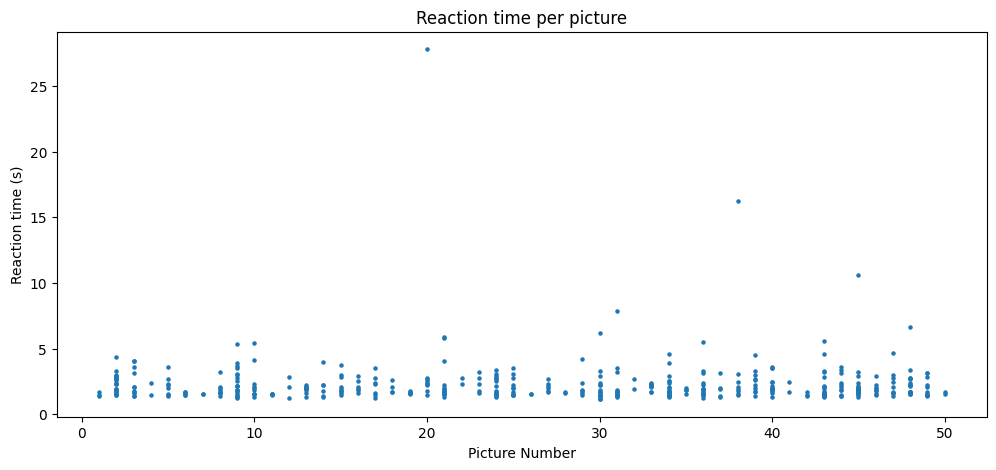

In [6]:
# plot computed reaction times
plt.figure(figsize=(12,5))
plt.scatter(data.df_exp['Picture Number'], data.df_exp['Reaction Time (computed)'], marker='.', s=20)
plt.title('Reaction time per picture')
plt.xlabel('Picture Number')
plt.ylabel('Reaction time (s)')
plt.show()

# Select Channels of Interest

In this section we will select the electrodes that are located in the region of interest, which in our case is the hippocampus.

In [7]:
# get indices of the hippocampal channels
idx = np.where(data.df_chan['DK_ROI'].str.contains(r'(hippo|Hippo|HIPPO)\w+'))[0]

# select only the hippocampal channels from the dataset
data.ieeg = data.ieeg[idx, :]
data.df_chan = data.df_chan.iloc[idx, :]
data.df_chan.reset_index(drop=True, inplace=True)
print(data.ieeg.shape)
display(data.df_chan)

(11, 1363811)


,elec_index,elec_label,DK_ROI,Prob,Lobe,x17Networks,Prob_1,x7Networks,Prob_2,BN_atlas,...,brodmann,Prob_4,perc_VTPM,Prob_5,Var16,data_chan,loc_1,loc_2,loc_3,name
0,87,801,Left_Hippocampus,0.74,H,NO_ROI,0.00,NO_ROI,0.00,Hipp_L_2_1,...,35,0.35,NO_ROI,0.0,NaN,72,-25.062528,16.505682,4.994733,B 01
1,88,802,Left_Hippocampus,0.91,H,NO_ROI,0.00,NO_ROI,0.00,Hipp_L_2_1,...,20,0.88,NO_ROI,0.0,NaN,73,-28.441106,16.699292,4.634672,B 02
2,89,803,Left_Hippocampus,0.99,H,NO_ROI,0.00,NO_ROI,0.00,Hipp_L_2_1,...,20,1.00,NO_ROI,0.0,NaN,74,-31.859375,16.928825,4.281605,B 03
3,90,804,Left_Hippocampus,0.93,H,NO_ROI,0.00,NO_ROI,0.00,Hipp_L_2_1,...,20,1.00,NO_ROI,0.0,NaN,75,-34.893603,17.125096,4.013083,B 04
4,103,901,Left_Hippocampus,0.81,H,NO_ROI,0.00,NO_ROI,0.00,Hipp_L_2_2,...,37,1.00,NO_ROI,0.0,NaN,79,-29.537444,2.146746,12.712468,C 01
5,104,902,Left_Hippocampus,0.79,H,NO_ROI,0.00,NO_ROI,0.00,Hipp_L_2_2,...,37,1.00,NO_ROI,0.0,NaN,80,-32.963128,1.901089,12.712735,C 02
6,105,903,Left_Hippocampus,0.46,H,NO_ROI,0.00,NO_ROI,0.00,Hipp_L_2_2,...,37,0.94,NO_ROI,0.0,NaN,81,-36.689494,1.650701,12.785543,C 03
7,183,1401,Right_Hippocampus,0.27,H,Networks_15,0.55,Networks_5,0.44,Hipp_R_2_1,...,30,0.62,NO_ROI,0.0,NaN,113,21.814157,20.246080,-0.149293,B' 01
8,184,1402,Right_Hippocampus,0.60,H,Networks_15,0.38,Networks_5,0.47,Hipp_R_2_1,...,30,0.65,NO_ROI,0.0,NaN,114,25.153117,20.736965,0.645246,B' 02
9,185,1403,Right_Hippocampus,0.74,H,NO_ROI,0.00,NO_ROI,0.00,Hipp_R_2_2,...,20,0.92,NO_ROI,0.0,NaN,115,28.628871,21.275221,1.441458,B' 03


# Clean Data

#### Remove outliers

From the histogram above we saw that there where some trials which the subject took a long time to place the picture at the estimated target location, we are not interested in trials which do not seem very plausible. The subject may have been doing other things during this trial, such as asking the experiment supervisor some questions or in other ways not being focused on the task at hand.

To remove outliers we will look at the reaction time distribution and remove trials that are more than 3 standard deviations from the average.

In [8]:
def determine_outlier_thresholds_std(dataframe, col_name):
    upper_boundary = dataframe[col_name].mean() + 3 * dataframe[col_name].std()
    lower_boundary = dataframe[col_name].mean() - 3 * dataframe[col_name].std()
    return lower_boundary, upper_boundary

def check_outliers_std(dataframe, col_name):
    lower_boundary, upper_boundary = determine_outlier_thresholds_std(dataframe, col_name)
    if dataframe[(dataframe[col_name] > upper_boundary) | (dataframe[col_name] < lower_boundary)].any(axis=None):
        return True
    else: 
        return False
    
def get_outlier_indices(dataframe, cols):
    data = []
    for col_name in cols:
        if col_name != 'Outcome':
            outliers_ = check_outliers_std(dataframe, col_name)
            count = None
            lower_limit, upper_limit = determine_outlier_thresholds_std(dataframe, col_name)
            if outliers_:
                count = dataframe[(dataframe[col_name] > upper_limit) | (dataframe[col_name] < lower_limit)][col_name].count()
                indices = dataframe[(dataframe[col_name] > upper_limit) | (dataframe[col_name] < lower_limit)].index.to_numpy()
            outliers_status = check_outliers_std(dataframe, col_name)
            data.append([outliers_, outliers_status, count, col_name, lower_limit, upper_limit])
    table = tabulate(data, headers=['Outlier (Previously)','Outliers','Count', 'Column','Lower Limit', 'Upper Limit'], tablefmt='rst', numalign='right')
    print("Removing Outliers using 3 Standard Deviation")
    print(table)
    return indices

idx = get_outlier_indices(
    dataframe=data.df_exp, 
    cols=['Reaction Time (RT)', 'Reaction Time (computed)']
)

Removing Outliers using 3 Standard Deviation
======================  ==========  =======  ========================  =============  =============
Outlier (Previously)    Outliers      Count  Column                      Lower Limit    Upper Limit
======================  ==========  =======  ========================  =============  =============
True                    True              4  Reaction Time (RT)              -2329.4        3874.72
True                    True              4  Reaction Time (computed)       -2.88215        7.46512
======================  ==========  =======  ========================  =============  =============


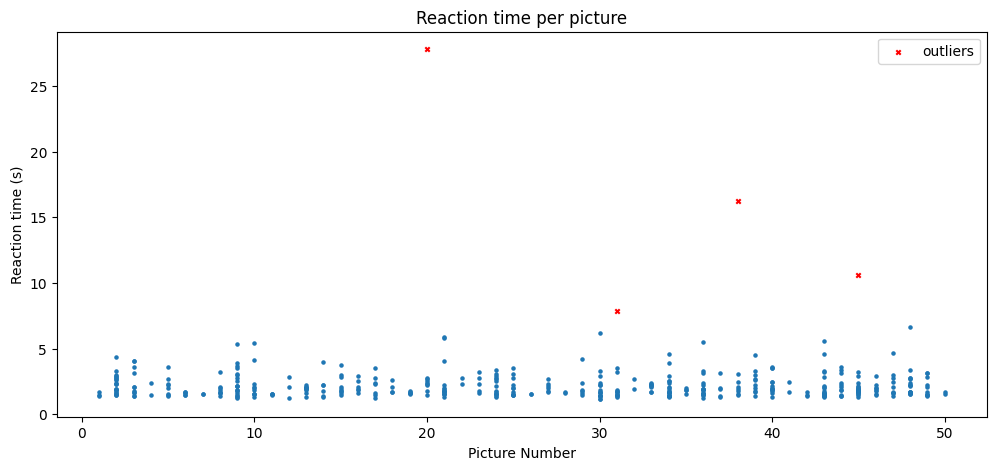

In [9]:
_df1 = data.df_exp.drop(idx)
_df2 = data.df_exp.iloc[idx, :]

# plot computed reaction times
plt.figure(figsize=(12,5))
plt.scatter(_df1['Picture Number'], _df1['Reaction Time (computed)'], marker='.', s=20)
plt.scatter(_df2['Picture Number'], _df2['Reaction Time (computed)'], marker='x', s=10, color='red', label='outliers')
plt.title('Reaction time per picture')
plt.xlabel('Picture Number')
plt.ylabel('Reaction time (s)')
plt.legend(loc='best')
plt.show()

# Re-reference Data

In [10]:
# Initiate re-referencing object
ref = hp.Rereference(verbose=True)

# Bipolar re-referencing
data_ref, removed_indices = ref.laplacian(
    data=data.ieeg,
    ch_names=data.df_chan['name'].to_numpy()
)

re-referencing method: 'laplacian'
remove_indices:  [0, 3]
remove_indices:  [0, 3, 7, 10]
remove_indices:  [0, 3, 7, 10, 4, 6]
successfully re-referenced data.


# Display Re-referenced Data using MNE Toolbox

In [12]:
%matplotlib qt5
%gui qt5

_df1 = data.df_chan.drop(removed_indices).reset_index(drop=True)

info = mne.create_info(
    ch_names=_df1['name'].to_list(),
    ch_types=['ecog'] * len(_df1['name']),
    sfreq=fs
)

raw = mne.io.RawArray(data_ref, info)
# n_channels=113, scalings='auto', title='Data from arrays', show=True, block=True
raw.plot(n_channels=len(data_ref), 
         scalings='auto', 
         show=True, 
        #  block=True,
         title=f"Subject {data.subject_id} - Experiment Phase {data.experiment_phase_of_interest}")
plt.show()

Creating RawArray with float64 data, n_channels=5, n_times=1363811
    Range : 0 ... 1363810 =      0.000 ...  2663.691 secs
Ready.


qt.qpa.xcb: X server does not support XInput 2
failed to get the current screen resources


Using matplotlib as 2D backend.


qt.glx: qglx_findConfig: Failed to finding matching FBConfig for QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
No XVisualInfo for format QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
Falling back to using screens root_visual.


qt.qpa.xcb: QXcbConnection: XCB error: 1 (BadRequest), sequence: 165, resource id: 90, major code: 130 (Unknown), minor code: 47
qt.qpa.xcb: QXcbConnection: XCB error: 170 (Unknown), sequence: 180, resource id: 90, major code: 146 (Unknown), minor code: 20


Channels marked as bad:
none


# Write Preprocessed Data to CSV File

In [13]:
df_data_ref = pd.DataFrame(data_ref.T, columns=_df1['name'].to_list())
df_data_ref.to_csv(f"./data/subject_{data.subject_id}_exp_phase_{data.experiment_phase_of_interest}_preprocessed.csv", index=False)

# Oscillation Detection

In [59]:
from ebosc.helpers import get_project_root
from ebosc.eBOSC_wrapper import eBOSC_wrapper
import os

In [73]:
# specify paths
pn = dict()
pn['root']  = os.path.join(os.getcwd(),'..')
# pn['examplefile'] = os.path.join(pn['root'],'data','1160_rest_EEG_Rlm_Fhl_rdSeg_Art_EC.csv')
pn['outfile'] = os.path.join(pn['root'],'example_out.npy')

# eBOSC parameters
cfg_eBOSC = dict()
cfg_eBOSC['F'] = 2 ** np.arange(1,6,.125)   # frequency sampling
cfg_eBOSC['wavenumber'] = 6                 # wavelet parameter (time-frequency tradeoff)
cfg_eBOSC['fsample'] = 500                  # current sampling frequency of EEG data
cfg_eBOSC['pad.tfr_s'] = 1                  # padding following wavelet transform to avoid edge artifacts in seconds (bi-lateral)
cfg_eBOSC['pad.detection_s'] = .5           # padding following rhythm detection in seconds (bi-lateral); 'shoulder' for BOSC eBOSC.detected matrix to account for duration threshold
cfg_eBOSC['pad.background_s'] = 1           # padding of segments for BG (only avoiding edge artifacts)
cfg_eBOSC['channel'] = []
cfg_eBOSC['trial'] = []
cfg_eBOSC['trial_background'] = []

# Threshold settings
cfg_eBOSC['threshold.excludePeak'] = np.array([[8,15]])   # lower and upper bound of frequencies to be excluded during background fit (Hz) (previously: LowFreqExcludeBG HighFreqExcludeBG)
cfg_eBOSC['threshold.duration'] = np.kron(np.ones((1,len(cfg_eBOSC['F']))),3) # vector of duration thresholds at each frequency (previously: ncyc)
cfg_eBOSC['threshold.percentile'] = .95    # percentile of background fit for power threshold

# general processing settings
cfg_eBOSC['postproc.use'] = 'yes'           # Post-processing of rhythmic eBOSC.episodes, i.e., wavelet 'deconvolution' (default = 'no')
cfg_eBOSC['postproc.method'] = 'FWHM'       # Deconvolution method (default = 'MaxBias', FWHM: 'FWHM')
cfg_eBOSC['postproc.edgeOnly'] = 'yes'      # Deconvolution only at on- and offsets of eBOSC.episodes? (default = 'yes')
cfg_eBOSC['postproc.effSignal'] = 'PT'      # Power deconvolution on whole signal or signal above power threshold? (default = 'PT')

# Run eBOSC
[eBOSC, cfg] = eBOSC_wrapper(cfg_eBOSC, df_data_ref)

Channel: B 02; Nr. 1/5


: 

In [69]:
df_data_ref = pd.DataFrame(data_ref.T, columns=_df1['name'].to_list())
df_data_ref['time'] = np.arange(0, data_ref.shape[1]/fs, 1/fs)
df_data_ref['time'] = df_data_ref['time'].apply(lambda x: round(x, 3))
df_data_ref['epoch'] = 0
df_data_ref['condition'] = 1
df_data_ref.head()

,B 02,B 03,C 02,B' 02,B' 03,time,epoch,condition
0,-11.985699,5.195932,-13.300423,-12.887842,14.105773,0.000,0,1
1,-11.598893,4.541852,-11.003101,-15.686856,16.133566,0.002,0,1
2,-13.421274,5.668686,-9.859696,-13.951356,14.647591,0.004,0,1
3,-14.114004,5.472398,-11.166515,-11.013531,12.909166,0.006,0,1
4,-15.460236,5.248437,-12.481810,-8.313555,10.404319,0.008,0,1


In [64]:
d = pd.read_csv('./data/1160_rest_EEG_Rlm_Fhl_rdSeg_Art_EC.txt', sep=',')
d.head()

,Unnamed: 0.1,Unnamed: 0,time,condition,epoch,Fp1,Fp2,AF7,AF3,AF4,...,PO9,PO7,PO3,POz,PO4,PO8,PO10,O1,Oz,O2
0,0,0,4.500,1,0,-4.777144,-5.337529,-9.456512,-5.787248,-8.125428,...,13.364978,11.179181,4.083631,-1.190842,-3.838353,-3.927580,3.900421,9.560754,4.556376,-2.801655
1,1,1,4.502,1,0,-5.987110,-6.798714,-10.748038,-7.750981,-7.942502,...,11.436876,7.595982,0.791407,-3.850624,-6.896337,-6.330258,0.958812,7.782682,2.551302,-5.945537
2,2,2,4.504,1,0,-6.026406,-4.917593,-11.335574,-7.936659,-6.079407,...,10.733507,5.735644,-0.237062,-4.315985,-6.212671,-6.735392,-0.411514,7.287872,2.820535,-6.678188
3,3,3,4.506,1,0,-6.033837,-2.423115,-11.169628,-7.844277,-7.244570,...,11.069614,5.510169,-0.165779,-3.762670,-3.381532,-5.700802,0.621264,7.314217,3.612484,-5.677450
4,4,4,4.508,1,0,-7.055700,-2.101783,-10.850244,-8.507871,-11.189631,...,10.251427,5.143548,-0.408545,-3.683719,-2.422026,-4.969408,1.783668,6.215382,2.923875,-5.234412


In [ ]:
detected_avg = eBOSC['detected'].mean(level=['frequency', 'time'])
detected_avg = detected_avg.pivot_table(index=['frequency'], columns='time')
cur_multiindex = eBOSC['detected'].index
cur_time = cur_multiindex.get_level_values('time').unique()
cur_freq = cur_multiindex.get_level_values('frequency').unique()

fig, ax = plt.subplots(nrows=1, ncols=1)
im = ax.imshow(detected_avg, aspect = 'auto')
[x0, x1] = ax.get_xlim()
[y0, y1] = ax.get_ylim()
xticks_loc = [t for t in ax.get_xticks() if t>=x0 and t<=x1]
yticks_loc = [t for t in ax.get_yticks() if t>=y1 and t<=y0]
x_label_list = np.round(cur_time[np.int_(xticks_loc)],1).tolist()
y_label_list = np.round(cur_freq[np.int_(yticks_loc)],1).tolist()
ax.set_xticks(xticks_loc)
ax.set_xticklabels(x_label_list)
ax.set_yticks(yticks_loc)
ax.set_yticklabels(y_label_list)
plt.colorbar(im, label='Proportion detected across trials')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Avg. detected rhythms across trials', fontsize=12)
plt.show()

In [ ]:
from fooof import FOOOF, FOOOFGroup

fm = FOOOF(peak_width_limits=[1.0, 8.0], max_n_peaks=6, min_peak_height=0.1,
           peak_threshold=2.0, aperiodic_mode='fixed')

# Initialize a FOOOFGroup object, specifying some parameters
fg = FOOOFGroup(peak_width_limits=[1.0, 8.0], max_n_peaks=8)

# Fit FOOOF model across the matrix of power spectra
fg.fit(freqs, spectra)

# Create and save out a report summarizing the results across the group of power spectra
fg.save_report()

# Save out FOOOF results for further analysis later
fg.save(file_name='fooof_group_results', save_results=True)

In [57]:
from mne_hfo import RMSDetector
detector = RMSDetector(filter_band=(0, 255))

# assume user has loaded in raw iEEG data using mne-python
detector.fit(raw)

# get the HFO events as an *events.tsv style dataframe
hfo_event_df = detector.hfo_event_df

# get the HFO events as an *events.tsv style dataframe
hfo_annot_df = detector.hfo_df

/tmp/ipykernel_21166/3633467362.py:5: RuntimeWarning: Sampling frequency of 512.0 is below the suggested rate of 2000. Please use with caution.
  detector.fit(raw)
100%|██████████| 5/5 [00:00<00:00, 1264.72it/s]


# Display Raw Data

#### Plot all electrodes in brain

First, convert the coordinates given in columns 'loc_1', 'loc_2', and 'loc_3' in the dataframe holding channel metadata (Data.df_chan).

In [ ]:
def mni305_to_mni152(xyz: np.ndarray) -> np.ndarray:
    """ Converts MNI305 coordinates (ie. RAS) to MNI152 coordinates
    
    Args:
        xyz (np.ndarray): MNI305 coordinates (ie. RAS coordinates)
    Returns:
        np.ndarray: MNI152 coordinates
    """
    point = np.append(xyz, 1)
    trans = np.array([[0.9975, -0.0073, 0.0176, -0.0429],
                      [0.0146, 1.0009, -0.0024, 1.5496],
                      [-0.0130, -0.0093,  0.9971, 1.1840]])
    return trans @ point

In [ ]:
%matplotlib qt5
%gui qt5

# Convert contact coordinates from RAS to MNI space
data.df_chan['mni152_coordinates'] = data.df_chan.apply(lambda row: mni305_to_mni152(np.array([row['loc_3'], row['loc_1'], row['loc_2']])), axis=1)

# Colour list for plotting contacts
color_includes = ['rosybrown', 'lightcoral', 'brown', 'maroon', 'red', 'salmon', 'tomato', 'sienna', 'chocolate', 'sandybrown',
                  'peru', 'darkorange', 'orange', 'tan', 'darkgoldenrod', 'goldenrod', 'gold', 'khaki', 'olive', 'yellow',
                  'olivedrab', 'yellowgreen', 'darkolivegreen', 'greenyellow', 'chartreuse', 'lime', 'limegreen',
                  'forestgreen', 'green', 'darkgreen', 'springgreen', 'mediumspringgreen', 'lightgreen', 'aquamarine',
                  'turquoise', 'lightseagreen', 'darkslategray', 'teal', 'cyan', 'deepskyblue', 'dodgerblue', 'royalblue',
                  'navy', 'blue', 'darkviolet', 'violet', 'purple', 'magenta', 'deeppink', 'crimson', 'pink']

# Number of unique electrodes in subject
num_electrodes = data.df_chan['name'].map(lambda x: x.split(' ')[0]).value_counts().size

# Create new column in dataframe to store colour for plotting contacts
data.df_chan['plot_colour'] = pd.Series()
for (name, count), colour in zip(data.df_chan['name'].map(lambda x: x.split(' ')[0]).value_counts().items(),
                              random.choices(color_includes, k=num_electrodes)):
    # get indices of contacts wrt name
    idx = np.where(data.df_chan['name'].str.contains(r'%s [0-9]{2}' % name))
    data.df_chan.loc[idx[0], 'plot_colour'] = colour

# plot contacts in brain
view = plotting.view_markers(marker_coords=data.df_chan['mni152_coordinates'].to_list(), marker_color=data.df_chan['plot_colour'].to_list(), marker_size=2)
view

#### Plot contacts in hippocampus

In [ ]:
idx = np.where(data.df_chan['DK_ROI'].str.contains(r'(hippo|Hippo|HIPPO)\w+'))[0]

# plot contacts in brain
view = plotting.view_markers(
    marker_coords=data.df_chan.loc[idx, 'mni152_coordinates'].to_list(), 
    marker_color=data.df_chan.loc[idx, 'plot_colour'].to_list(), 
    marker_size=2)
view

### Visualise Using MNE Toolbox
#### Trace plot of all contacts

In [ ]:
data.df_chan.loc[data.df_chan['name'] == 'G 03']

In [ ]:
%matplotlib qt5
%gui qt5

info = mne.create_info(
    ch_names=data.df_chan['name'].to_list(),
    ch_types=['ecog'] * len(data.df_chan['name']),
    sfreq=fs
)

raw = mne.io.RawArray(data.ieeg, info)
# n_channels=113, scalings='auto', title='Data from arrays', show=True, block=True
raw.plot(n_channels=52, 
         scalings='auto', 
         show=True, 
        #  block=True,
         title=f"Subject {data.subject_id} - Experiment Phase {data.experiment_phase_of_interest}")
plt.show()

In [ ]:
# create 2D array with zeros of same length as other channels
stim_arr = np.zeros((1, len(data.ieeg[0])))

# get indices from dataframe with experiment metadata
idx_pic_shown = data.df_exp['Mark for Picture Shown'].to_numpy()
idx_pic_placed = data.df_exp['Mark for Picture Placed'].to_numpy()

# set indices to 1, this will be the stimulus channel
stim_arr[0, idx_pic_shown] = 1
stim_arr[0, idx_pic_placed] = 2

# delete if present
# if raw['STI'] is not None:
#     raw.drop_channels(['STI'])

# create info object for stimulus channel
info = mne.create_info(
    ch_names=['STI'], 
    sfreq=raw.info['sfreq'], 
    ch_types=['stim'])

# create raw array with trigger channel
stim_raw = mne.io.RawArray(stim_arr, info)

# add stimulus channel to raw object
raw.add_channels([stim_raw], force_update_info=True)

# find events from stimulus channel
events = mne.find_events(raw, stim_channel="STI")

# create mapping between event_id to event description
event_dict = {
    '1': "picture shown",
    '2': "picture placed"
}

epochs = mne.Epochs(
    raw,
    events,
    event_id=event_dict,
    tmin=-0.2,
    tmax=0.5,
    reject=None,
    preload=True,
)

#### Trace plot of contacts in hippocampus

In [ ]:
idx = np.where(data.df_chan['DK_ROI'].str.contains(r'(hippo|Hippo|HIPPO)\w+'))[0]

info = mne.create_info(
    ch_names=data.df_chan.loc[idx, 'name'].to_list(),
    ch_types=['eeg'] * len(data.ieeg[idx]),
    sfreq=fs
)

raw_roi = mne.io.RawArray(data.ieeg[idx], info)
# n_channels=113, scalings='auto', title='Data from arrays', show=True, block=True
raw_roi.plot(n_channels=len(idx),
         scalings='auto', 
         show=True, 
        #  block=True,
         title=f"Subject {data.subject_id} - Experiment Phase {data.experiment_phase_of_interest}")
plt.show()

#### Plot Events on Channel Traces

Procedure:
1. Create and add stimulus channel to raw object
2. Find events from stimulus channel
3. Create annotations from events
4. Plot annotations

In [ ]:
# create 2D array with zeros of same length as other channels
stim_arr = np.zeros((1, len(data.ieeg[0])))

# get indices from dataframe with experiment metadata
idx_pic_shown = data.df_exp['Mark for Picture Shown'].to_numpy()
idx_pic_placed = data.df_exp['Mark for Picture Placed'].to_numpy()

# set indices to 1, this will be the stimulus channel
stim_arr[0, idx_pic_shown] = 1
stim_arr[0, idx_pic_placed] = 2

# delete if present
# if raw['STI'] is not None:
#     raw.drop_channels(['STI'])

# create info object for stimulus channel
info = mne.create_info(
    ch_names=['STI'], 
    sfreq=raw.info['sfreq'], 
    ch_types=['stim'])

# create raw array with trigger channel
stim_raw = mne.io.RawArray(stim_arr, info)

# add stimulus channel to raw object
raw_roi.add_channels([stim_raw], force_update_info=True)

# find events from stimulus channel
events = mne.find_events(raw_roi, stim_channel="STI")

# create mapping between event_id to event description
event_dict = {
    1: "picture shown",
    2: "picture placed"
}

# create annotations from events
annot_from_events = mne.annotations_from_events(
    events=events,
    event_desc=event_dict,
    sfreq=raw_roi.info["sfreq"],
    orig_time=raw_roi.info["meas_date"],
)
raw_roi.set_annotations(annot_from_events)

# plot
raw_roi.plot(start=8,
         duration=10,
         scalings='auto', 
         show=True, 
        #  block=True,
         title=f"Subject {data.subject_id} - Experiment Phase {data.experiment_phase_of_interest}")
plt.show()

# ICA

In [ ]:
filt_raw = raw.copy().filter(l_freq=0.5, h_freq=None)

ica = mne.preprocessing.ICA(n_components=12, method='fastica', random_state=23, max_iter=800)
ica.fit(filt_raw)
ica

In [ ]:
explained_var_ratio = ica.get_explained_variance_ratio(filt_raw)
for channel_type, ratio in explained_var_ratio.items():
    print(
        f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
    )
    
explained_var_ratio = ica.get_explained_variance_ratio(
    filt_raw, components=[0], ch_type="eeg"
)
# This time, print as percentage.
ratio_percent = round(100 * explained_var_ratio["eeg"])
print(
    f"Fraction of variance in EEG signal explained by first component: "
    f"{ratio_percent}%"
)

In [ ]:
ica.plot_sources(filt_raw_roi, show_scrollbars=True)
plt.show()

In [ ]:
filt_raw_roi = raw_roi.copy().filter(l_freq=0.5, h_freq=None)

ica = mne.preprocessing.ICA(n_components=10, method='picard', random_state=23, max_iter=800)
ica.fit(filt_raw_roi)
ica

In [ ]:
data.df_chan['name']

In [ ]:
explained_var_ratio = ica.get_explained_variance_ratio(filt_raw_roi)
for channel_type, ratio in explained_var_ratio.items():
    print(
        f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
    )
    
explained_var_ratio = ica.get_explained_variance_ratio(
    filt_raw_roi, components=[0], ch_type="eeg" 
)
# This time, print as percentage.
ratio_percent = round(100 * explained_var_ratio["eeg"])
print(
    f"Fraction of variance in EEG signal explained by first component: "
    f"{ratio_percent}%"
)

In [ ]:
ica.plot_sources(filt_raw_roi, show_scrollbars=True)
plt.show()

In [ ]:
ica.exclude = [0, 1]

# ica.apply() changes the Raw object in-place, so let's first make a copy
reconst_raw = raw_roi.copy()
ica.apply(reconst_raw)


raw_roi.plot(scalings='auto', 
             show=True, 
            #  block=True,
             title=f"Subject {data.subject_id} - Experiment Phase {data.experiment_phase_of_interest} - Pre Artifact Removal"
)
reconst_raw.plot(scalings='auto', 
                 show=True, 
                #  block=True,
                 title=f"Subject {data.subject_id} - Experiment Phase {data.experiment_phase_of_interest} - Post Artifact Removal"
)
plt.show()
del reconst_raw

In [ ]:
data.df_chan['name'].map(lambda x: x.split(' ')[0]).unique()

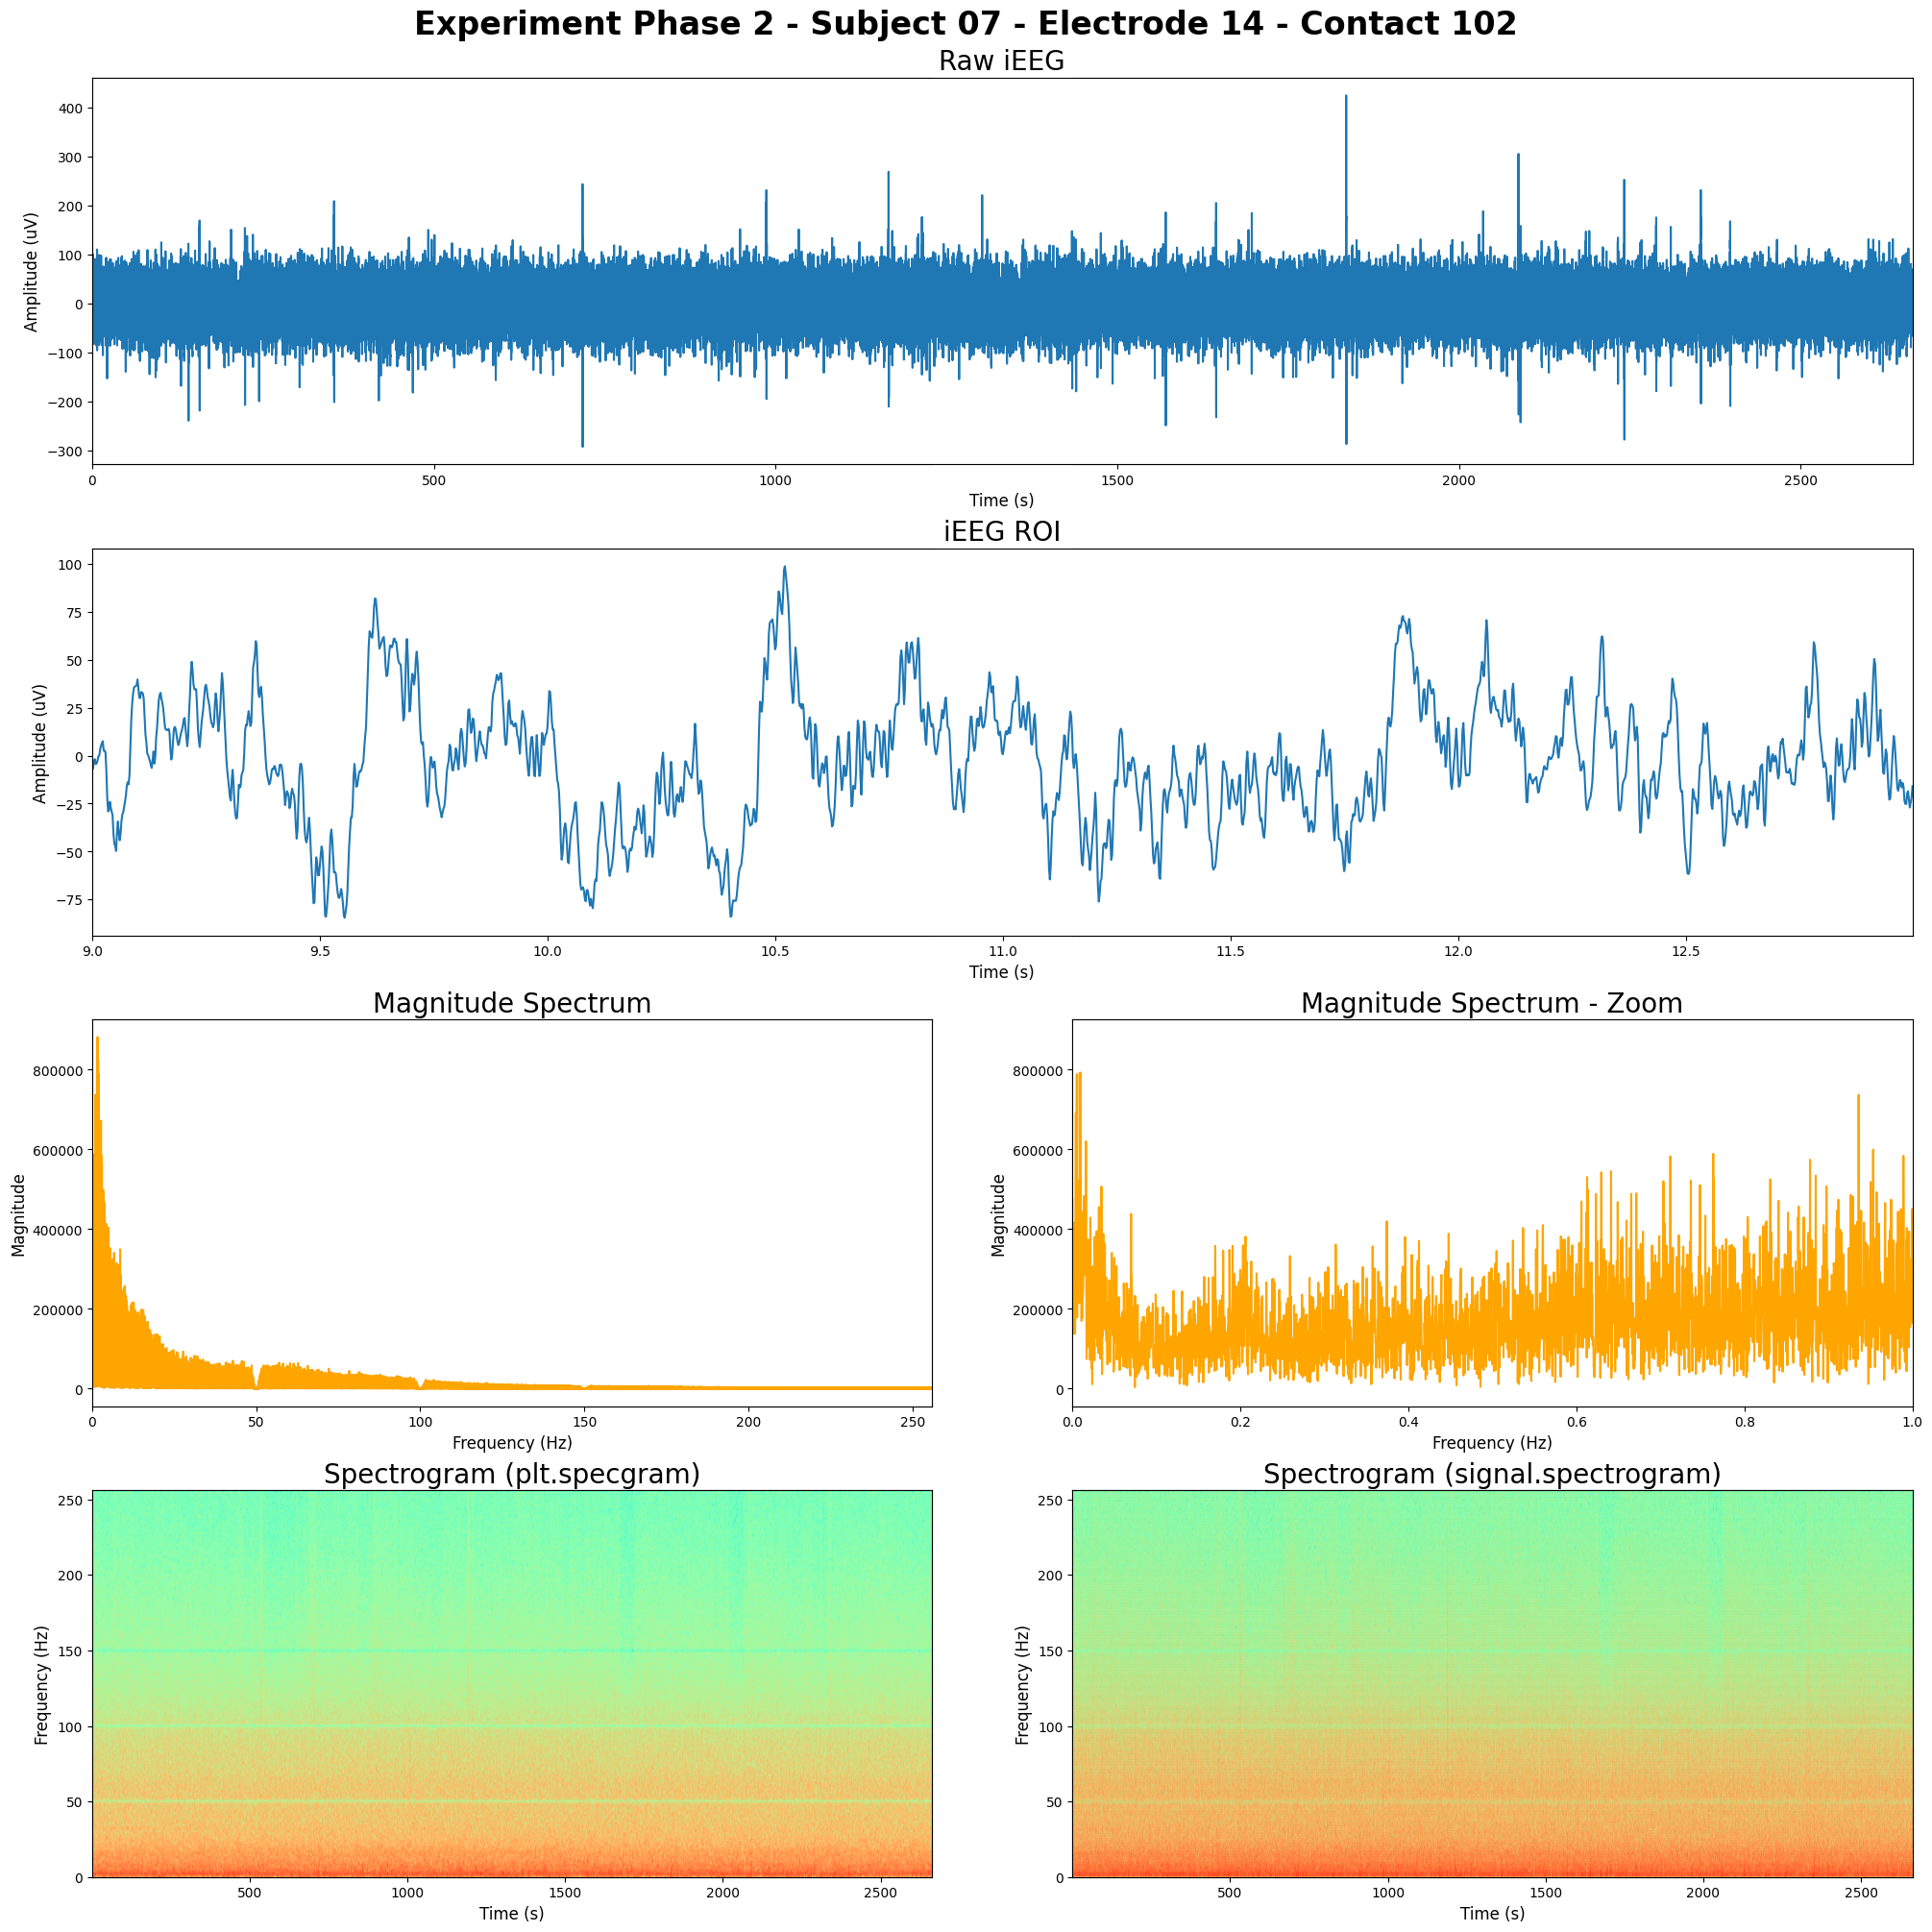

In [5]:
#******** Variable definitions ********
electrode_num = 14                                          # electrode to inspect
ieeg_contact_num = 102                                      # single iEEG contact to inspect
roi = [9, 13]                                               # ROI in seconds

#******** Static definitions ********
fs = 512                                                    # sample frequency
TT = data.ieeg.shape[1] / fs  # total time in seconds
t = np.arange(0, TT, 1/fs)                                  # full time vector
t_roi = np.arange(roi[0], roi[1], 1/fs)                     # ROI time vector

#******** Fourier transform ********
y = fft(data.ieeg[ieeg_contact_num, :])                     # FFT
xf = fftfreq(data.ieeg[ieeg_contact_num, :].size, 1/fs)     # Frequency vector
xf = xf[xf>=0]                                              # Only positive frequencies
y = np.abs(y)[:len(xf)]                                     # Magnitude of FFT (one sided)


#******** Plotting ********
fig, ax = plt.subplots(
    nrows=4, 
    ncols=2, 
    figsize=(20, 20),
    layout='constrained')
# Remove default x and y ticks (will be added during add_subplot)
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

# Entire signal
gs1 = ax[0, 0].get_gridspec()
ax1 = fig.add_subplot(gs1[0, 0:])
ax1.plot(t, data.ieeg[ieeg_contact_num, :])
ax1.set_title('Raw iEEG', fontsize=20)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Amplitude (uV)', fontsize=12)
ax1.set_xlim([t[0], t[-1]])

# ROI
gs2 = ax[1, 0].get_gridspec()
ax2 = fig.add_subplot(gs2[1, 0:])
ax2.plot(t_roi, data.ieeg[ieeg_contact_num, roi[0]*fs:roi[1]*fs])
ax2.set_title('iEEG ROI', fontsize=20)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Amplitude (uV)', fontsize=12)
ax2.set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum - Entire signal
gs3 = ax[2, 0].get_gridspec()
ax3 = fig.add_subplot(gs3[2, 0])
ax3.plot(xf, y, color='orange')
ax3.set_title('Magnitude Spectrum', fontsize=20)
ax3.set_xlabel('Frequency (Hz)', fontsize=12)
ax3.set_ylabel('Magnitude', fontsize=12)
ax3.set_xlim([xf[0], xf[-1]])

# Magnitude spectrum - Zoom
gs4 = ax[2, 0].get_gridspec()
ax4 = fig.add_subplot(gs4[2, 1])
ax4.plot(xf, y, color='orange')
ax4.set_title('Magnitude Spectrum - Zoom', fontsize=20)
ax4.set_xlabel('Frequency (Hz)', fontsize=12)
ax4.set_ylabel('Magnitude', fontsize=12)
ax4.set_xlim([0, 1])

# Spectrogram - Entire signal
gs5 = ax[3, 0].get_gridspec()
ax5 = fig.add_subplot(gs5[3, 0])
pxx, freqs, _t, img = ax5.specgram(data.ieeg[ieeg_contact_num, :], Fs=fs, NFFT=512, noverlap=64, cmap='rainbow')
ax5.set_title('Spectrogram (plt.specgram)', fontsize=20)
ax5.set_xlabel('Time (s)', fontsize=12)
ax5.set_ylabel('Frequency (Hz)', fontsize=12)

gs6 = ax[3, 0].get_gridspec()
ax6 = fig.add_subplot(gs6[3, 1])
_f, _t, Sxx = signal.spectrogram(data.ieeg[ieeg_contact_num, :], fs, nfft=512, noverlap=64)
ax6.pcolormesh(_t, _f, 10*np.log10(Sxx), shading='gouraud', cmap='rainbow')
ax6.set_title('Spectrogram (signal.spectrogram)', fontsize=20)
ax6.set_xlabel('Time (s)', fontsize=12)
ax6.set_ylabel('Frequency (Hz)', fontsize=12)

fig.suptitle(f"Experiment Phase {experiment_phase_of_interest} - Subject {data.subject_id} - Electrode {electrode_num} - Contact {ieeg_contact_num}", fontsize=24, fontweight='bold')
# plt.tight_layout()
plt.show()

# 1. Remove Bad Channels

In [ ]:
raw.plot(start=8,
         duration=10,
         scalings='auto', 
         show=True, 
        #  block=True,
         title=f"Subject {data.subject_id} - Experiment Phase {data.experiment_phase_of_interest}")
plt.show()

# 2. Re-reference

In [ ]:
data.ieeg[0].dtype

In [ ]:
ref = hp.Rereference(data.ieeg, verbose=True)

print(ref.monopolar(ref_channel=2, inplace=False))
print(ref.monopolar(ref_channel=2, inplace=True))

In [ ]:
reref = hp.Rereference()
neighbour_ieeg = data.ieeg[0+1, :]

print("\nPre re-referencing:")
print(data.ieeg[0, :])
print("\nNeighbour channel:")
print(neighbour_ieeg)
print()
tmp = reref.bipolar(data.ieeg[0, :], neighbour_ieeg)
print("\nPost re-referencing:")
print(tmp)

In [ ]:
#******** Initiate rereference object ********
reref = hp.Rereference()


#******** Re-reference single channel using bipolar montage ********
data_preref = data.ieeg[ieeg_contact_num, :] # Save state of data before re-referencing
neighbour_ieeg = data.ieeg[ieeg_contact_num+1, :]
data_reref = reref.bipolar(data.ieeg[ieeg_contact_num, :], neigbour_ieeg)

In [ ]:
data_preref = data.ieeg[0, :] # Save state of data before re-referencing

#******** Fourier transform ********
# Pre-referencing
y_pre = fft(data_preref)                                    # FFT
xf_pre = fftfreq(data_preref.size, 1/fs)                    # Frequency vector
xf_pre = xf_pre[xf_pre>=0]                                  # Only positive frequencies
y_pre = np.abs(y_pre)[:len(xf_pre)]                         # Magnitude of FFT (one sided)
# Post-referencing
y = fft(tmp)                     # FFT
xf = fftfreq(tmp.size, 1/fs)     # Frequency vector
xf = xf[xf>=0]                                              # Only positive frequencies
y = np.abs(y)[:len(xf)]                                     # Magnitude of FFT (one sided)


#******** Plotting ********
fig, ax = plt.subplots(
    nrows=5, 
    ncols=2, 
    figsize=(20, 20),
    layout='constrained')
# Remove default x and y ticks (will be added during add_subplot)
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

# Pre-referencing 
# Entire signal
gs1 = ax[0, 0].get_gridspec()
ax1 = fig.add_subplot(gs1[0, 0])
ax1.plot(t, data_preref)
ax1.set_title('Pre Re-referencing\niEEG', fontsize=20)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Amplitude (uV)', fontsize=12)
ax1.set_xlim([t[0], t[-1]])

# ROI
gs2 = ax[1, 0].get_gridspec()
ax2 = fig.add_subplot(gs2[1, 0])
ax2.plot(t_roi, data_preref[roi[0]*fs:roi[1]*fs])
ax2.set_title('iEEG ROI', fontsize=20)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Amplitude (uV)', fontsize=12)
ax2.set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum - Entire signal
gs3 = ax[2, 0].get_gridspec()
ax3 = fig.add_subplot(gs3[2, 0])
ax3.plot(xf_pre, y_pre, color='orange')
ax3.set_title('Magnitude Spectrum', fontsize=20)
ax3.set_xlabel('Frequency (Hz)', fontsize=12)
ax3.set_ylabel('Magnitude', fontsize=12)
ax3.set_xlim([xf[0], xf[-1]])

# Magnitude spectrum - Zoom
gs4 = ax[3, 0].get_gridspec()
ax4 = fig.add_subplot(gs4[3, 0])
ax4.plot(xf_pre, y_pre, color='orange')
ax4.set_title('Magnitude Spectrum - Zoom', fontsize=20)
ax4.set_xlabel('Frequency (Hz)', fontsize=12)
ax4.set_ylabel('Magnitude', fontsize=12)
ax4.set_xlim([0, 1])

gs5 = ax[4, 0].get_gridspec()
ax5 = fig.add_subplot(gs5[4, 0])
_f_pre, _t_pre, Sxx_pre = signal.spectrogram(data_preref, fs, nfft=512, noverlap=64)
ax5.pcolormesh(_t_pre, _f_pre, 10*np.log10(Sxx_pre), shading='gouraud', cmap='rainbow')
ax5.set_title('Spectrogram (signal.spectrogram)', fontsize=20)
ax5.set_xlabel('Time (s)', fontsize=12)
ax5.set_ylabel('Frequency (Hz)', fontsize=12)

# Post-referencing 
# Entire signal
gs6 = ax[0, 0].get_gridspec()
ax6 = fig.add_subplot(gs6[0, 1])
ax6.plot(t, tmp)
ax6.set_title('Post Re-referencing\niEEG', fontsize=20)
ax6.set_xlabel('Time (s)', fontsize=12)
ax6.set_ylabel('Amplitude (uV)', fontsize=12)
ax6.set_xlim([t[0], t[-1]])

# ROI
gs7 = ax[1, 0].get_gridspec()
ax7 = fig.add_subplot(gs7[1, 1])
ax7.plot(t_roi, data.ieeg[ieeg_contact_num, roi[0]*fs:roi[1]*fs])
ax7.set_title('iEEG ROI', fontsize=20)
ax7.set_xlabel('Time (s)', fontsize=12)
ax7.set_ylabel('Amplitude (uV)', fontsize=12)
ax7.set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum - Entire signal
gs8 = ax[2, 0].get_gridspec()
ax8 = fig.add_subplot(gs8[2, 1])
ax8.plot(xf, y, color='orange')
ax8.set_title('Magnitude Spectrum', fontsize=20)
ax8.set_xlabel('Frequency (Hz)', fontsize=12)
ax8.set_ylabel('Magnitude', fontsize=12)
ax8.set_xlim([xf[0], xf[-1]])

# Magnitude spectrum - Zoom
gs9 = ax[3, 0].get_gridspec()
ax9 = fig.add_subplot(gs9[3, 1])
ax9.plot(xf, y, color='orange')
ax9.set_title('Magnitude Spectrum - Zoom', fontsize=20)
ax9.set_xlabel('Frequency (Hz)', fontsize=12)
ax9.set_ylabel('Magnitude', fontsize=12)
ax9.set_xlim([0, 1])

gs10 = ax[4, 0].get_gridspec()
ax10 = fig.add_subplot(gs6[4, 1])
_f, _t, Sxx = signal.spectrogram(tmp, fs, nfft=512, noverlap=64)
ax10.pcolormesh(_t, _f, 10*np.log10(Sxx), shading='gouraud', cmap='rainbow')
ax10.set_title('Spectrogram (signal.spectrogram)', fontsize=20)
ax10.set_xlabel('Time (s)', fontsize=12)
ax10.set_ylabel('Frequency (Hz)', fontsize=12)

fig.suptitle(f"Experiment Phase {experiment_phase_of_interest} - Subject {data.subject_id} - Electrode {electrode_num} - Contact {ieeg_contact_num}", fontsize=24, fontweight='bold')
# plt.tight_layout()
plt.show()

In [ ]:
#******** Fourier transform ********
# Pre-referencing
y_pre = fft(data_preref)                                    # FFT
xf_pre = fftfreq(data_preref.size, 1/fs)                    # Frequency vector
xf_pre = xf_pre[xf_pre>=0]                                  # Only positive frequencies
y_pre = np.abs(y_pre)[:len(xf_pre)]                         # Magnitude of FFT (one sided)
# Post-referencing
y = fft(data.ieeg[ieeg_contact_num, :])                     # FFT
xf = fftfreq(data.ieeg[ieeg_contact_num, :].size, 1/fs)     # Frequency vector
xf = xf[xf>=0]                                              # Only positive frequencies
y = np.abs(y)[:len(xf)]                                     # Magnitude of FFT (one sided)


#******** Plotting ********
fig, ax = plt.subplots(
    nrows=5, 
    ncols=2, 
    figsize=(20, 20),
    layout='constrained')
# Remove default x and y ticks (will be added during add_subplot)
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

# Pre-referencing 
# Entire signal
gs1 = ax[0, 0].get_gridspec()
ax1 = fig.add_subplot(gs1[0, 0])
ax1.plot(t, data_preref)
ax1.set_title('Pre Re-referencing\niEEG', fontsize=20)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Amplitude (uV)', fontsize=12)
ax1.set_xlim([t[0], t[-1]])

# ROI
gs2 = ax[1, 0].get_gridspec()
ax2 = fig.add_subplot(gs2[1, 0])
ax2.plot(t_roi, data_preref[roi[0]*fs:roi[1]*fs])
ax2.set_title('iEEG ROI', fontsize=20)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Amplitude (uV)', fontsize=12)
ax2.set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum - Entire signal
gs3 = ax[2, 0].get_gridspec()
ax3 = fig.add_subplot(gs3[2, 0])
ax3.plot(xf_pre, y_pre, color='orange')
ax3.set_title('Magnitude Spectrum', fontsize=20)
ax3.set_xlabel('Frequency (Hz)', fontsize=12)
ax3.set_ylabel('Magnitude', fontsize=12)
ax3.set_xlim([xf[0], xf[-1]])

# Magnitude spectrum - Zoom
gs4 = ax[3, 0].get_gridspec()
ax4 = fig.add_subplot(gs4[3, 0])
ax4.plot(xf_pre, y_pre, color='orange')
ax4.set_title('Magnitude Spectrum - Zoom', fontsize=20)
ax4.set_xlabel('Frequency (Hz)', fontsize=12)
ax4.set_ylabel('Magnitude', fontsize=12)
ax4.set_xlim([0, 1])

gs5 = ax[4, 0].get_gridspec()
ax5 = fig.add_subplot(gs5[4, 0])
_f_pre, _t_pre, Sxx_pre = signal.spectrogram(data_preref, fs, nfft=512, noverlap=64)
ax5.pcolormesh(_t_pre, _f_pre, 10*np.log10(Sxx_pre), shading='gouraud', cmap='rainbow')
ax5.set_title('Spectrogram (signal.spectrogram)', fontsize=20)
ax5.set_xlabel('Time (s)', fontsize=12)
ax5.set_ylabel('Frequency (Hz)', fontsize=12)

# Post-referencing 
# Entire signal
gs6 = ax[0, 0].get_gridspec()
ax6 = fig.add_subplot(gs6[0, 1])
ax6.plot(t, data.ieeg[ieeg_contact_num, :])
ax6.set_title('Post Re-referencing\niEEG', fontsize=20)
ax6.set_xlabel('Time (s)', fontsize=12)
ax6.set_ylabel('Amplitude (uV)', fontsize=12)
ax6.set_xlim([t[0], t[-1]])

# ROI
gs7 = ax[1, 0].get_gridspec()
ax7 = fig.add_subplot(gs7[1, 1])
ax7.plot(t_roi, data.ieeg[ieeg_contact_num, roi[0]*fs:roi[1]*fs])
ax7.set_title('iEEG ROI', fontsize=20)
ax7.set_xlabel('Time (s)', fontsize=12)
ax7.set_ylabel('Amplitude (uV)', fontsize=12)
ax7.set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum - Entire signal
gs8 = ax[2, 0].get_gridspec()
ax8 = fig.add_subplot(gs8[2, 1])
ax8.plot(xf, y, color='orange')
ax8.set_title('Magnitude Spectrum', fontsize=20)
ax8.set_xlabel('Frequency (Hz)', fontsize=12)
ax8.set_ylabel('Magnitude', fontsize=12)
ax8.set_xlim([xf[0], xf[-1]])

# Magnitude spectrum - Zoom
gs9 = ax[3, 0].get_gridspec()
ax9 = fig.add_subplot(gs9[3, 1])
ax9.plot(xf, y, color='orange')
ax9.set_title('Magnitude Spectrum - Zoom', fontsize=20)
ax9.set_xlabel('Frequency (Hz)', fontsize=12)
ax9.set_ylabel('Magnitude', fontsize=12)
ax9.set_xlim([0, 1])

gs10 = ax[4, 0].get_gridspec()
ax10 = fig.add_subplot(gs6[4, 1])
_f, _t, Sxx = signal.spectrogram(data.ieeg[ieeg_contact_num, :], fs, nfft=512, noverlap=64)
ax10.pcolormesh(_t, _f, 10*np.log10(Sxx), shading='gouraud', cmap='rainbow')
ax10.set_title('Spectrogram (signal.spectrogram)', fontsize=20)
ax10.set_xlabel('Time (s)', fontsize=12)
ax10.set_ylabel('Frequency (Hz)', fontsize=12)

fig.suptitle(f"Experiment Phase {experiment_phase_of_interest} - Subject {data.subject_id} - Electrode {electrode_num} - Contact {ieeg_contact_num}", fontsize=24, fontweight='bold')
# plt.tight_layout()
plt.show()

# 2. Filter Signal

In [ ]:
def digital_filter(in_signal=None, order=4, cutoff=500, fs=1000, filter_type='high', apply_filter=False, show_bodeplot=True, show_impulse_response=True, len_impulse=1000):
    """digital_filter Create a digital filter using scipy's butter function.

    Create a digital filter using scipy's butter function and compute the
    filter frequency response. The filter frequency response is always plotted
    as part in ensuring the desired filter design.

    Args:
        in_signal (_type_, optional): If specified and apply_filter is set to True, the filter is applied to the signal 
                                      and the filtered signal is returned. Defaults to None.
        order (int, optional): The order of the filter. Defaults to 4.
        cutoff (int or vector, optional): The cutoff frequency of the filter (in Hz). If filter_type is 'bandpass' or
                                          'bandstop' cutoff is a length-2 vector. Defaults to 500.
        fs (int, optional): The sampling frequency used to sample the signal. Defaults to 1000.
        filter_type (str, optional): The type of filter ('lowpass', 'highpass', 'bandstop', 'bandpass'). Defaults to 'high'.
        apply_filter (bool, optional): If True then the filter is applied to the signal in_signal. Filter will be applied forward
                                       and backward on the signal to eliminate phase shift. Defaults to False.
        show_bodeplot (bool, optional): If True then the bode plot of the filter frequency response is plotted. Defaults to True.
        show_impulse_response (bool, optional): If True then the impulse response of the filter is plotted. Defaults to True.
        len_impulse (int, optional): The length of the impulse response. If not specified defaults to 1000.

    Returns:
        b, a (ndarray): Default setting for function is to return the 
                        filter coefficients.
        out_signal (ndarray): If apply_filter is set to True and in_signal 
                              is given, the function will apply the digital 
                              filter and return the filtered signal.
    """
    # Create digital filter
    b, a = signal.butter(N=order, Wn=cutoff, btype=filter_type, fs=fs, analog=False)
    
    # Compute digital filter frequency response
    w, h = signal.freqz(b, a, fs=fs)
    
    # Generate and compute impulse response
    impulse = signal.unit_impulse(len_impulse)                                  # create impulse
    t_impulse = np.arange(-(len_impulse//10), len_impulse-(len_impulse//10))    # create time vector for impulse
    response = signal.lfilter(b, a, impulse)                                    # compute filter response to impulse
    
    # Plotting
    if show_bodeplot and show_impulse_response:
        fig, ax = plt.subplots(1, 2, figsize=(20, 7))
        # Bode plot
        ax[0].semilogx(w, 20*np.log10(abs(h)), linewidth=3)
        ax[0].set_title("Digital Filter Frequency Response", fontsize=20)
        ax[0].set_xlabel("Frequency [Hz]", fontsize=16)
        ax[0].set_ylabel("Amplitude [dB]", fontsize=16)
        ax[0].grid(which='both', axis='both')
        if filter_type in ('low', 'lowpass'): ax[0].margins(0, 0.15)
        if filter_type in ('high', 'highpass'): ax[0].margins(0.15, 0.1)
        if filter_type in ('bs', 'bandstop', 'bp', 'bandpass'): 
            ax[0].axvline(cutoff[0], color='orange', label=f"Cutoff frequency start ({cutoff[0]} Hz)", linewidth=2, linestyle='--')
            ax[0].axvline(cutoff[1], color='orange', label=f"Cutoff frequency stop ({cutoff[1]} Hz)", linewidth=2, linestyle='--')
        if filter_type not in ('bs', 'bandstop', 'bp', 'bandpass'): 
            ax[0].semilogx(cutoff, 20*np.log10(0.5*np.sqrt(2)), '*') # plot a star symbol at -3 dB attenuation
            ax[0].axvline(cutoff, color='orange', label=f"Cutoff frequency ({cutoff} Hz)", linewidth=2, linestyle='--')
        # Impulse response plot
        ax[1].plot(t_impulse, impulse, 'b-', label='Impulse')
        ax[1].plot(t_impulse, response, 'g-', linewidth=2, label='Response')
        ax[1].set_title('Impulse and Response of Digital Filter', fontsize=20)
        ax[1].set_xlabel('Time [sec]', fontsize=16)
        ax[1].set_ylabel('Amplitude', fontsize=16)
        ax[1].grid(which='both', axis='both')
        plt.legend(loc='best', fontsize=12, shadow=True)
        plt.tight_layout()
    elif show_bodeplot:
        fig, ax = plt.subplots(1, 1, figsize=(12, 7))
        ax[0].semilogx(w, 20*np.log10(abs(h)), linewidth=3)
        ax[0].set_title("Digital Filter Frequency Response", fontsize=20)
        ax[0].set_xlabel("Frequency [Hz]", fontsize=16)
        ax[0].set_ylabel("Amplitude [dB]", fontsize=16)
        ax[0].grid(which='both', axis='both')
        if filter_type in ('low', 'lowpass'): ax[0].margins(0, 0.15)
        if filter_type in ('high', 'highpass'): ax[0].margins(0.15, 0.1)
        if filter_type in ('bs', 'bandstop', 'bp', 'bandpass'): 
            ax[0].axvline(cutoff[0], color='orange', label=f"Cutoff frequency start ({cutoff[0]} Hz)", linewidth=2, linestyle='--')
            ax[0].axvline(cutoff[1], color='orange', label=f"Cutoff frequency stop ({cutoff[1]} Hz)", linewidth=2, linestyle='--')
        if filter_type not in ('bs', 'bandstop', 'bp', 'bandpass'): 
            ax[0].semilogx(cutoff, 20*np.log10(0.5*np.sqrt(2)), '*') # plot a star symbol at -3 dB attenuation
            ax[0].axvline(cutoff, color='orange', label=f"Cutoff frequency ({cutoff} Hz)", linewidth=2, linestyle='--')
        plt.legend(loc='best', fontsize=12, shadow=True)
        plt.tight_layout()
    elif show_impulse_response:
        fig, ax = plt.subplots(1, 1, figsize=(12, 7))
        ax[0].plot(t_impulse, impulse, 'b-', label='Impulse')
        ax[0].plot(t_impulse, response, 'g-', linewidth=2, label='Response')
        ax[0].set_title('Impulse and Response of Digital Filter', fontsize=20)
        ax[0].set_xlabel('Time [sec]', fontsize=16)
        ax[0].set_ylabel('Amplitude', fontsize=16)
        ax[0].grid(which='both', axis='both')
        plt.legend(loc='best', fontsize=12, shadow=True)
        plt.tight_layout()
    else:
        pass
    
    if apply_filter == True and in_signal is not None:
        # Apply filter forward and backward to eliminate phase shift
        out_signal = signal.sosfiltfilt(b, a, in_signal)
        return out_signal
    else:
        # (Defualt) Return the filter coefficients
        return b, a

In [ ]:
#******** Highpass filter data ********
# Note:
#   Remove low frequency drifts.
data.ieeg_filtered = digital_filter(in_signal=data.ieeg[ieeg_contact_num, :],
                                        order=5,
                                        cutoff=2,
                                        filter_type='highpass',
                                        fs=fs,
                                        apply_filter=True)


#******** Fourier transform ********
y_pre = fft(data.ieeg[ieeg_contact_num, :])                      # FFT
xf_pre = fftfreq(data.ieeg[ieeg_contact_num, :].size, 1/fs)      # Frequency vector
xf_pre = xf_pre[xf_pre>=0]                                      # Only positive frequencies
y_pre = np.abs(y_pre)[:len(xf_pre)]                             # Magnitude of FFT (one sided)

y_post = fft(data.ieeg_filtered)                             # FFT
xf_post = fftfreq(data.ieeg_filtered.size, 1/fs)             # Frequency vector
xf_post = xf_post[xf_post>=0]                                   # Only positive frequencies
y_post = np.abs(y_post)[:len(xf_post)]                          # Magnitude of FFT (one sided)


#******** Plotting (pre filtering) ********
fig, ax = plt.subplots(4, 2, figsize=(20, 20))

# Entire signal
ax[0,0].plot(t, data.ieeg[ieeg_contact_num, :])
ax[0,0].set_title('Pre Filter\nRaw iEEG', fontsize=20)
ax[0,0].set_xlabel('Time (s)', fontsize=12)
ax[0,0].set_ylabel('Amplitude (uV)', fontsize=12)
ax[0,0].set_xlim([t[0], t[-1]])

# ROI
ax[1,0].plot(t_roi, data.ieeg[ieeg_contact_num, roi[0]*fs:roi[1]*fs])
ax[1,0].set_title('iEEG ROI', fontsize=20)
ax[1,0].set_xlabel('Time (s)', fontsize=12)
ax[1,0].set_ylabel('Amplitude (uV)', fontsize=12)
ax[1,0].set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum
ax[2,0].plot(xf_pre, y_pre, color='orange')
ax[2,0].set_title('Magnitude Spectrum', fontsize=20)
ax[2,0].set_xlabel('Frequency (Hz)', fontsize=12)
ax[2,0].set_ylabel('Magnitude', fontsize=12)
ax[2,0].set_xlim([xf_pre[0], xf_pre[-1]])

# Spectrogram
pxx_pre, freqs_pre, _t_pre, img_pre = ax[3,0].specgram(data.ieeg[ieeg_contact_num, :], Fs=fs, NFFT=512, noverlap=64, cmap='rainbow')
ax[3,0].set_title('Spectrogram', fontsize=20)
ax[3,0].set_xlabel('Time (s)', fontsize=12)
ax[3,0].set_ylabel('Frequency (Hz)', fontsize=12)

#******** Plotting (post filtering) ********
# Entire signal
ax[0,1].plot(t, data.ieeg_filtered)
ax[0,1].set_title('Post Filter\nRaw iEEG', fontsize=20)
ax[0,1].set_xlabel('Time (s)', fontsize=12)
ax[0,1].set_ylabel('Amplitude (uV)', fontsize=12)
ax[0,1].set_xlim([t[0], t[-1]])

# ROI
ax[1,1].plot(t_roi, data.ieeg_filtered[roi[0]*fs:roi[1]*fs])
ax[1,1].set_title('iEEG ROI', fontsize=20)
ax[1,1].set_xlabel('Time (s)', fontsize=12)
ax[1,1].set_ylabel('Amplitude (uV)', fontsize=12)
ax[1,1].set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum
ax[2,1].plot(xf_post, y_post, color='orange')
ax[2,1].set_title('Magnitude Spectrum', fontsize=20)
ax[2,1].set_xlabel('Frequency (Hz)', fontsize=12)
ax[2,1].set_ylabel('Magnitude', fontsize=12)
ax[2,1].set_xlim([xf_post[0], xf_post[-1]])

# Spectrogram
pxx_post, freqs_post, _t_post, img_post = ax[3,1].specgram(data.ieeg_filtered, Fs=fs, NFFT=512, noverlap=64, cmap='rainbow')
ax[3,1].set_title('Spectrogram', fontsize=20)
ax[3,1].set_xlabel('Time (s)', fontsize=12)
ax[3,1].set_ylabel('Frequency (Hz)', fontsize=12)

fig.suptitle(f"Experiment Phase {experiment_phase_of_interest} - Subject {data.subject_id}", fontsize=24, fontweight='bold')
plt.tight_layout()

In [ ]:
# temporary variable holding pre highpass filtered data
tmp_dataone_highpass = data.ieeg_filtered

#******** Bandstop filter data ********
# Note:
#   Remove powerline frequency noise.
data.ieeg_filtered = digital_filter(in_signal=data.ieeg_filtered,
                                        order=5,
                                        cutoff=[48, 52],
                                        filter_type='bandstop',
                                        fs=fs,
                                        apply_filter=True)


#******** Fourier transform ********
# pre filtering
y_pre = fft(tmp_dataone_highpass)                               # FFT
xf_pre = fftfreq(tmp_dataone_highpass.size, 1/fs)               # Frequency vector
xf_pre = xf_pre[xf_pre>=0]                                      # Only positive frequencies
y_pre = np.abs(y_pre)[:len(xf_pre)]                             # Magnitude of FFT (one sided)
# post filtering
y_post = fft(data.ieeg_filtered)                             # FFT
xf_post = fftfreq(data.ieeg_filtered.size, 1/fs)             # Frequency vector
xf_post = xf_post[xf_post>=0]                                   # Only positive frequencies
y_post = np.abs(y_post)[:len(xf_post)]                          # Magnitude of FFT (one sided)


#******** Plotting (pre filtering) ********
fig, ax = plt.subplots(4, 2, figsize=(20, 20))

# Entire signal
ax[0,0].plot(t, tmp_dataone_highpass)
ax[0,0].set_title('Pre Filter\nRaw iEEG', fontsize=20)
ax[0,0].set_xlabel('Time (s)', fontsize=12)
ax[0,0].set_ylabel('Amplitude (uV)', fontsize=12)
ax[0,0].set_xlim([t[0], t[-1]])

# ROI
ax[1,0].plot(t_roi, tmp_dataone_highpass[roi[0]*fs:roi[1]*fs])
ax[1,0].set_title('iEEG ROI', fontsize=20)
ax[1,0].set_xlabel('Time (s)', fontsize=12)
ax[1,0].set_ylabel('Amplitude (uV)', fontsize=12)
ax[1,0].set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum
ax[2,0].plot(xf_pre, y_pre, color='orange')
ax[2,0].set_title('Magnitude Spectrum', fontsize=20)
ax[2,0].set_xlabel('Frequency (Hz)', fontsize=12)
ax[2,0].set_ylabel('Magnitude', fontsize=12)
ax[2,0].set_xlim([xf_pre[0], xf_pre[-1]])

# Spectrogram
pxx_pre, freqs_pre, _t_pre, img_pre = ax[3,0].specgram(tmp_dataone_highpass, Fs=fs, NFFT=512, noverlap=64, cmap='rainbow')
ax[3,0].set_title('Spectrogram', fontsize=20)
ax[3,0].set_xlabel('Time (s)', fontsize=12)
ax[3,0].set_ylabel('Frequency (Hz)', fontsize=12)

#******** Plotting (post filtering) ********
# Entire signal
ax[0,1].plot(t, data.ieeg_filtered)
ax[0,1].set_title('Post Filter\nRaw iEEG', fontsize=20)
ax[0,1].set_xlabel('Time (s)', fontsize=12)
ax[0,1].set_ylabel('Amplitude (uV)', fontsize=12)
ax[0,1].set_xlim([t[0], t[-1]])

# ROI
ax[1,1].plot(t_roi, data.ieeg_filtered[roi[0]*fs:roi[1]*fs])
ax[1,1].set_title('iEEG ROI', fontsize=20)
ax[1,1].set_xlabel('Time (s)', fontsize=12)
ax[1,1].set_ylabel('Amplitude (uV)', fontsize=12)
ax[1,1].set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum
ax[2,1].plot(xf_post, y_post, color='orange')
ax[2,1].set_title('Magnitude Spectrum', fontsize=20)
ax[2,1].set_xlabel('Frequency (Hz)', fontsize=12)
ax[2,1].set_ylabel('Magnitude', fontsize=12)
ax[2,1].set_xlim([xf_post[0], xf_post[-1]])

# Spectrogram
pxx_post, freqs_post, _t_post, img_post = ax[3,1].specgram(data.ieeg_filtered, Fs=fs, NFFT=512, noverlap=64, cmap='rainbow')
ax[3,1].set_title('Spectrogram', fontsize=20)
ax[3,1].set_xlabel('Time (s)', fontsize=12)
ax[3,1].set_ylabel('Frequency (Hz)', fontsize=12)

fig.suptitle(f"Experiment Phase {experiment_phase_of_interest} - Subject {data.subject_id}", fontsize=24, fontweight='bold')
plt.tight_layout()

# Save Preprocessed Data